In [1]:
import torch
import torch.nn as nn
import numpy as np
import pylab as plt

/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
all_imgs = []
all_labels = []

# Create a dataset in which the sum of pixels corresponds to the true probability of the label = 1
img_shape = (3, 32, 32)
for i in range(101):
    n_pixel = np.prod(img_shape)
    p = float(i) / 100
    labels = torch.empty(1000).bernoulli_(p=p).long()
    imgs = torch.zeros(1000, n_pixel).float()

    for i in range(len(imgs)):
        # randomly set p percent of the pixels of an image to one
        indices = torch.randperm(n_pixel)[:int(p*n_pixel)]
        imgs[i, indices] = 1
    # imgs[:, :int(p*n_pixel)] = 1
    imgs = imgs.view(len(imgs), *img_shape)
    all_imgs.append(imgs)
    all_labels.append(labels)

data = torch.cat(all_imgs)
labels = torch.cat(all_labels)

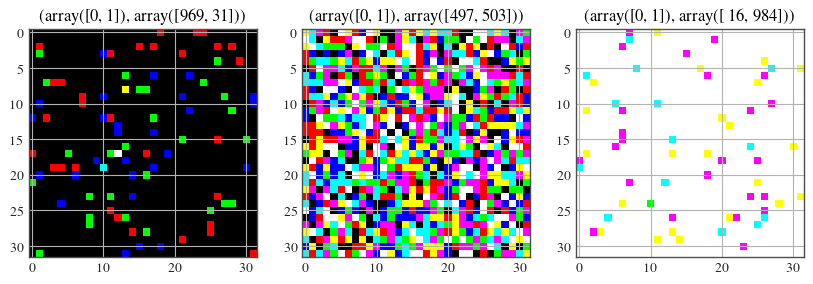

In [34]:
plt.subplot(131)
idx = 3000
plt.title(np.unique(labels[idx:idx+1000], return_counts=True))
plt.imshow(data[3000].permute(1, 2, 0))

plt.subplot(132)
idx = 50_000
plt.title(np.unique(labels[idx:idx+1000], return_counts=True))
plt.imshow(data[50000].permute(1, 2, 0))
plt.subplot(133)

idx = -3001
plt.title(np.unique(labels[idx:idx+1000], return_counts=True))
plt.imshow(data[-3000].permute(1, 2, 0))
plt.show()

In [44]:
from dal_toolbox.models.deterministic.resnet import ResNet18
from dal_toolbox.models.deterministic.train import train_one_epoch
from dal_toolbox.models.deterministic.evaluate import evaluate

dataset = torch.utils.data.TensorDataset(data, labels)
rnd_indices = np.random.permutation(len(dataset))
train_ds = torch.utils.data.Subset(dataset, indices=rnd_indices[:300])
test_ds = torch.utils.data.Subset(dataset, indices=rnd_indices[90_000:])

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, drop_last=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)

model = ResNet18(num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=.01, momentum=.9, weight_decay=0.0)
criterion = nn.CrossEntropyLoss()

for i in range(100):
    train_one_epoch(model, train_loader, criterion, optimizer, epoch=i, device='cuda')
evaluate(model, test_loader, {}, criterion, device='cuda')

  Train:  [0/2] eta: 0:00:00 lr: 0.01 loss: 0.7411 (0.7411) acc1: 50.7812 (50.7812) time: 0.0544 data: 0.0010 max mem: 894
  Train:  Total time: 0:00:00
  Train:  [0/2] eta: 0:00:00 lr: 0.01 loss: 0.5474 (0.5474) acc1: 64.8438 (64.8438) time: 0.0523 data: 0.0008 max mem: 894
  Train:  Total time: 0:00:00
  Train:  [0/2] eta: 0:00:00 lr: 0.01 loss: 0.3118 (0.3118) acc1: 83.5938 (83.5938) time: 0.0455 data: 0.0008 max mem: 894
  Train:  Total time: 0:00:00
  Train:  [0/2] eta: 0:00:00 lr: 0.01 loss: 0.1559 (0.1559) acc1: 96.0938 (96.0938) time: 0.0455 data: 0.0009 max mem: 894
  Train:  Total time: 0:00:00
  Train:  [0/2] eta: 0:00:00 lr: 0.01 loss: 0.0658 (0.0658) acc1: 99.2188 (99.2188) time: 0.0454 data: 0.0008 max mem: 894
  Train:  Total time: 0:00:00
  Train:  [0/2] eta: 0:00:00 lr: 0.01 loss: 0.0327 (0.0327) acc1: 100.0000 (100.0000) time: 0.0456 data: 0.0008 max mem: 894
  Train:  Total time: 0:00:00
  Train:  [0/2] eta: 0:00:00 lr: 0.01 loss: 0.0083 (0.0083) acc1: 100.0000 (100.

{'test_acc1': 73.46363067626953,
 'test_prec': 0.7346650227453093,
 'test_loss': 0.9756376147270203,
 'test_nll': 0.9756376147270203,
 'test_tce': 0.18612098693847656,
 'test_mce': 0.19281873106956482}

tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0.,  172.,  410.,  390.,
         436.,  458.,  681., 1000., 7177.])

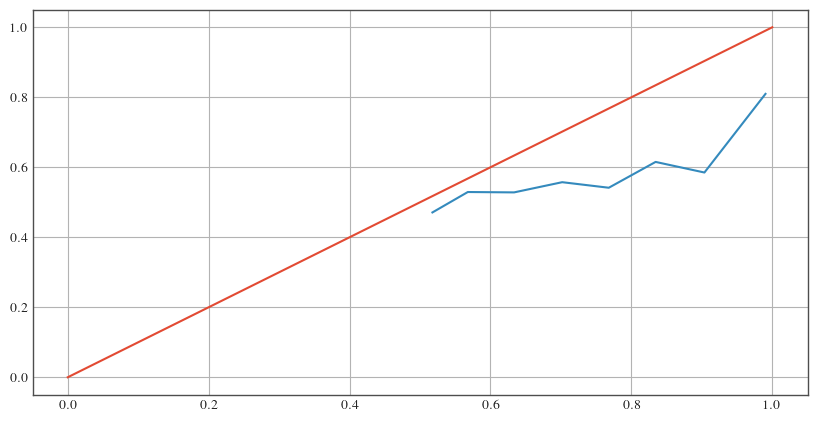

In [45]:
from dal_toolbox.metrics.calibration import TopLabelCalibrationError

def get_logits_and_labels(model, dataloader, device='cuda'):
    model.cuda()
    all_logits, all_targets = [], []
    for inputs, targets in dataloader:
        with torch.no_grad():
            logits = model(inputs.cuda())
        all_logits.append(logits.cpu())
        all_targets.append(targets)
    logits = torch.cat(all_logits)
    targets = torch.cat(all_targets)
    return logits, targets

logits, targets = get_logits_and_labels(model, test_loader)
tce_criterion = TopLabelCalibrationError()
tce_criterion.forward(logits.softmax(-1), targets)

plt.plot([0, 1], [0, 1])
plt.plot(tce_criterion.results['confs'], tce_criterion.results['accs'])
tce_criterion.results['n_samples']